# Fetch data

In [1]:
import pld
from pathlib import Path
import ipywidgets as ipw
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
DATASET = "20250127_170419"
DATAPATH = (Path(".") / DATASET).absolute()

In [3]:
analyzer = pld.RHEEDAnalyzer()
analyzer.set_outdir(DATAPATH / "output")

In [4]:
analyzer.load_data(DATAPATH)

In [5]:
analyzer.crop_to_global_region_of_interest()

In [6]:
frame = pld.RHEEDFrame(7, analyzer.data[7])

In [7]:
frame.plot( show_peaks=True,
   show_regions_of_interest=True,
    figsize=(4, 3))



# Extract time series

In [8]:
# intensities = analyzer.get_peak_intensities(sigma=1)

In [9]:
# import csv

# with open("central_peak_intensity_time_series.csv", "w") as f:
#     writer = csv.writer(f)
#     writer.writerow(["time", "intensity"])
#     for t, i in zip(analyzer.timestamps, intensities[0]):
#         writer.writerow([t, i])

## RHEED frame analysis

### Single frame check

In [10]:
analyzer.generate_frames(
    sigma=1,
    params={
        "min_distance": 10,
        "threshold_rel": 0.1,
        "width": 18,
        "height": 70,
    }
)


In [11]:
import importlib
importlib.reload(pld)
def plot_frame(frame: pld.RHEEDFrame):
    clear_output(wait=True)
    frame.plot(
        show_peaks=True,
        show_regions_of_interest=True,
        figsize=(4, 3),
    )


plot_frame(analyzer.frames[0])

rheed_slider = ipw.IntSlider(min=0, max=len(analyzer.frames) - 1)


def on_slider_change(change):
    plot_frame(analyzer.frames[change["new"]])


rheed_slider.observe(on_slider_change, names="value")

In [12]:
rheed_slider

IntSlider(value=0, max=2686)

In [13]:
bg_sub=analyzer.get_bg_subtracted_ROIs(bg_method="linear",annulus_pad=2)
fit_params = analyzer.fit_all_bg_subtracted_ROIs(bg_method="linear", annulus_pad=2)


In [14]:
fitted = analyzer.build_gaussian_fit_arrays(bg_sub, fit_params)


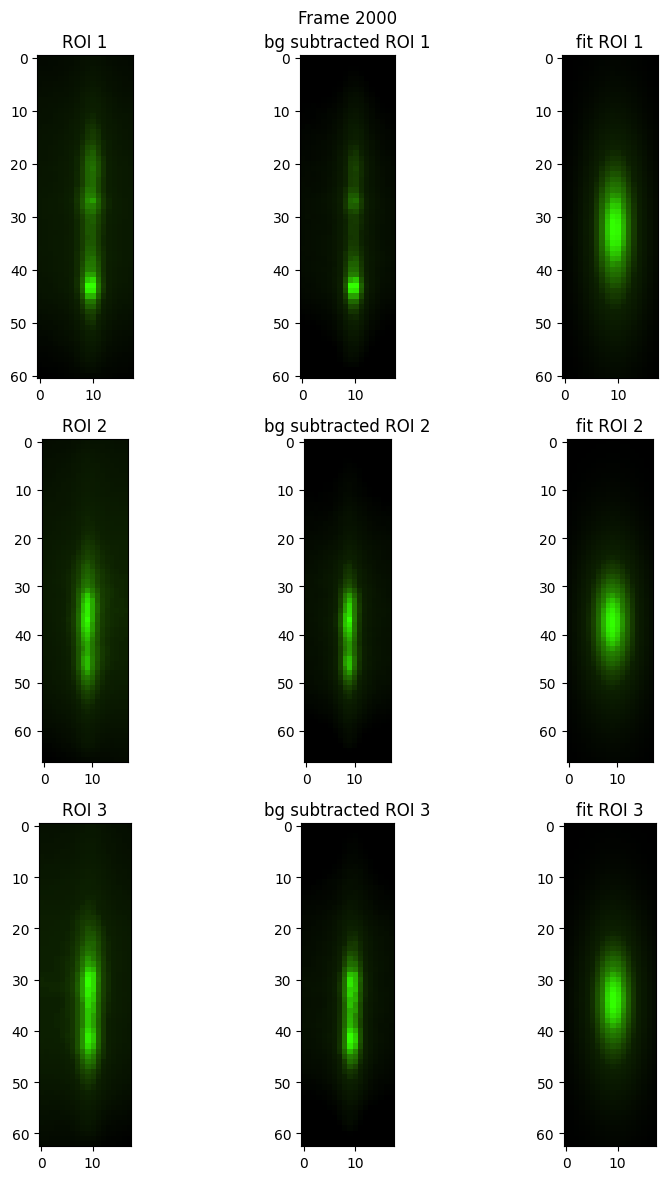

In [15]:
from matplotlib.colors import LinearSegmentedColormap
colors = [
    (0.00, "#000000"),
    (0.60, "#0C2000"),
    (0.75, "#184000"),
    (0.90, "#247F00"),
    (1.00, "#32FF00"),
]

# Crea una colormap matplotlib
cmap = LinearSegmentedColormap.from_list("my_green_map", colors)

nf=2000
frame0=analyzer.frames[nf]

img=frame0.data

fig,ax=plt.subplots(3, 3, figsize=(9, 12))

for i, (t, b, l, r) in enumerate(frame0.ROIs):
    roi = frame0.data[t:b, l:r]
    ax[i,0].imshow(roi, cmap=cmap)
    ax[i,0].set_title('ROI {}'.format(i+1))

bg_sub=analyzer.get_bg_subtracted_ROIs(bg_method="linear",annulus_pad=2)
for i in range(len(frame0.ROIs)):
    ax[i,1].imshow(bg_sub[nf][i], cmap=cmap)
    ax[i,1].set_title('bg subtracted ROI {}'.format(i+1)) 

for i in range(len(frame0.ROIs)):
    ax[i,2].imshow(fitted[nf][i], cmap=cmap)
    ax[i,2].set_title('fit ROI {}'.format(i+1))
fig.suptitle('Frame {}'.format(nf)) 
plt.tight_layout()
plt.show()
#analyzer.plot_integrated_ROIs()



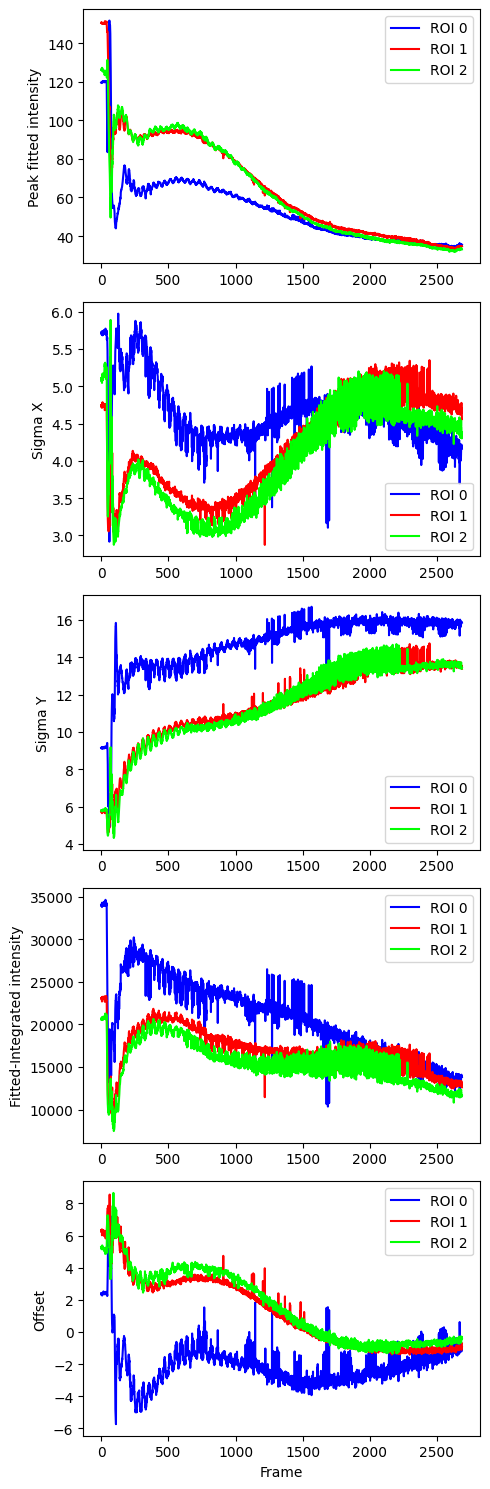

In [16]:

# Number of frames and ROIs
n_frames = len(fit_params)
n_rois = len(fit_params[0])

# Prepare array of shape (n_frames, n_rois)
peak_intensities = np.zeros((n_frames, n_rois))
sigma_x_values = np.zeros((n_frames, n_rois))
sigma_y_values = np.zeros((n_frames, n_rois))
offset_values = np.zeros((n_frames, n_rois))
for i in range(n_frames):
    for j in range(n_rois):
        amp, x0, y0, sx, sy, offset = fit_params[i][j]
        # peak intensity from Gaussian = amplitude + offset
        peak_intensities[i, j] = amp + offset
        sigma_x_values[i, j] = sx
        sigma_y_values[i, j] = sy
        offset_values[i, j] = offset


integrated = np.zeros((n_frames, n_rois), float)
for i in range(n_frames):
    for j in range(n_rois):
        integrated[i, j] = fitted[i][j].sum()

colors = ["blue", "red", "lime"]
fig, ax = plt.subplots(5, 1, figsize=(5, 15))

for roi_index in range(n_rois):
    ax[0].plot(np.arange(n_frames),peak_intensities[:, roi_index],label=f"ROI {roi_index}",color=colors[roi_index])
    ax[1].plot(np.arange(n_frames),sigma_x_values[:, roi_index],label=f"ROI {roi_index}",color=colors[roi_index])
    ax[2].plot(np.arange(n_frames),sigma_y_values[:, roi_index],label=f"ROI {roi_index}",color=colors[roi_index])
    ax[3].plot(np.arange(n_frames),integrated[:, roi_index],label=f"ROI {roi_index}",color=colors[roi_index])
    ax[4].plot(np.arange(n_frames),offset_values[:, roi_index],label=f"ROI {roi_index}",color=colors[roi_index])

ax[4].set_xlabel("Frame")
ax[0].set_ylabel("Peak fitted intensity")

ax[1].set_ylabel("Sigma X")
ax[2].set_ylabel("Sigma Y")
ax[3].set_ylabel("Fitted-Integrated intensity")
ax[4].set_ylabel("Offset")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

plt.tight_layout()
plt.show()



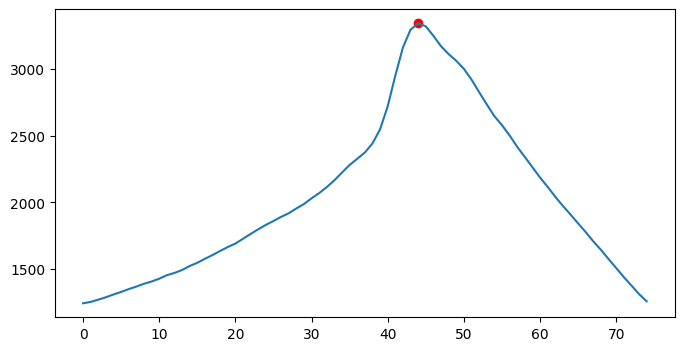

In [17]:
def plot_spectrum(frame: pld.RHEEDFrame):
    spectrum = frame.get_center_peak_cross_section()
    peaks, _ = find_peaks(spectrum, distance=20 // 2, prominence=25)

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum, label="Vertical Intensity Profile")
    plt.scatter(peaks, spectrum[peaks], color="red", label="Detected Peaks")
    # plt.ylim(2, 10)
    plt.show()


plot_spectrum(analyzer.frames[0])

cross_section_slider = ipw.IntSlider(min=0, max=len(analyzer.frames) - 1)


def on_slider_change(change):
    plot_spectrum(analyzer.frames[change["new"]])


cross_section_slider.observe(on_slider_change, names="value")

In [18]:
cross_section_slider

IntSlider(value=0, max=2686)

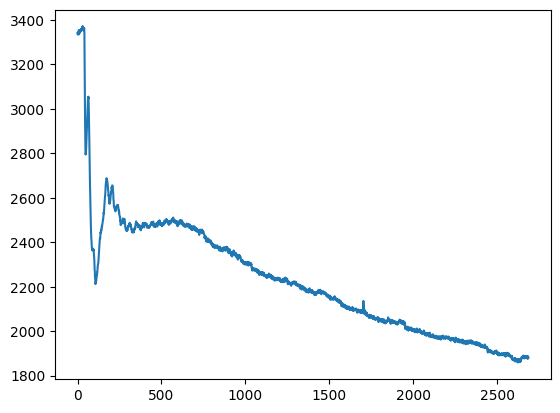

In [19]:
spectra = []
max_spectra = []
for frame in analyzer.frames:
    spectrum = frame.get_center_peak_cross_section()
    spectra.append(spectrum)
    max_spectra.append(np.max(spectrum))
plt.plot(max_spectra)


In [20]:
import plotly.graph_objects as go

ratios = [frame.get_peak_ratio_sum(prominence=25) for frame in analyzer.frames]

fig = go.Figure()
fig.add_trace(go.Scatter(y=ratios, mode="markers"))
fig.update_layout(
    xaxis=dict(range=[0, len(ratios)]),
)

In [21]:
# frame.plot_power_spectrum(figsize=(4, 3))

In [22]:
# Plottare solo la ROI del picco centrale
frame = analyzer.frames[0]

# Estrai la ROI del picco centrale (indice 1)
top, bottom, left, right = frame.ROIs[1]  # 0=sinistra, 1=centro, 2=destra

# Estrai la regione dell'immagine
roi_data = frame.data[top:bottom, left:right]

# Visualizza (con transpose per allineare x e y correttamente)
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=roi_data,
        colorscale="Viridis",
    )
)
fig.update_layout(
    title="ROI Picco Centrale",
    xaxis_title="X (pixel)",
    yaxis_title="Y (pixel)",
    yaxis=dict(autorange="reversed"),  # Inverti Y per allineare con immagine
)
fig.show()

# Time series

In [23]:
analyzer.plot_sharpness_time_series(
    data=analyzer.get_sharpness(),
    figsize=(8, 4),
)

In [24]:
analyzer.plot_radial_profile_time_series(
    data=analyzer.get_radial_profile(),
    figsize=(8, 4),
)

In [25]:
import numpy as np

analyzer.plot_intensity_time_series(
    data=np.array(analyzer.get_peak_intensities()) / 255,
    figsize=(4, 4),
)

# Score

In [26]:
analyzer.compute_deposition_score()

np.float64(1.0)

In [27]:
# analyzer.analyze_quality(0)

In [28]:
assert False

AssertionError: 

# Optimization

In [ ]:
from bayes_opt import BayesianOptimization

from bayes_opt import acquisition

acq = acquisition.UpperConfidenceBound(kappa=2.5)


def evaluate_growth_quality(
    gas_pressure,
    lase_fluence,
    substrate_temperature,
    i=0,
):
    """
    Replace this with your actual function that evaluates growth quality.
    It could run an experiment or use a surrogate model.
    """
    # Placeholder: Assume we have a function that scores growth quality
    score = analyzer.analyze_quality(i)
    return score


pbounds = {
    "gas_pressure": (1e-6, 1e-2),  # Torr
    "lase_fluence": (0.1, 1.0),  # J/cm^2
    "substrate_temperature": (500, 800),  # K
}

optimizer = BayesianOptimization(
    f=None,
    acquisition_function=acq,
    pbounds=pbounds,
    verbose=0,
    random_state=42,
)

max_iter = 10
for i in range(10):
    next_point = optimizer.suggest()
    result = evaluate_growth_quality(**next_point, i=i % 3)
    score = result["decay_rate"]
    optimizer.register(params=next_point, target=score)
    print(score, next_point)

print(optimizer.max)

# egobox